Group Name: Anonymous

Group members:

- Shuang Jie Zhu 33432457

- Kaicheng Huang 34253572

- Yuhang Peng 34278818

- Jingmin Zhu 34265597 

# FIT5226 Project

## Stage 2 - Deep Q-Learning
***

### 1. Imports

The following scripts imports essential libraries including `numpy` for numerical operations, `random` for generating random values, `torch` for deep learning operations, `copy` for handling deep object copying, and `time` for tracking execution time. Additionally, it uses `matplotlib.pyplot` for data visualisation, `mpatches` and `ListedColormap` for customising plot elements, and `FuncAnimation` from `matplotlib.animation` for creating dynamic visualisations.

In [1]:
# Use the TkAgg backend in matplotlib to display both plots and animations.
import matplotlib
matplotlib.use('TkAgg')

In [2]:
# Importing the required libraries
import numpy as np
import random
import torch
import copy
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

***

### 2. Environment Setup

##### **Environment description**

A single agent operates within a grid environment where the task is to pick up the item at a randomly determined location $A$ and deliver it to a target location $B$, which is also randomly determined for each episode. The grid world is defined as a square grid of size $n \times n$, with $n$ being a parameterisable dimension with a default value of 4. The agent begins at a random location on the grid and must navigate to the item location $A$, pick it up and then deliver it to the target location $B$. During this process, the agent can also observe both the item and target locations.

##### **Assumptions for initial agent, item and target locations**
- Item location cannot be the same as initial agent location.
- Item location cannot be the same as target location.

##### **State space**

The state space in the current Deep Q-Learning (DQL) implementation is richer compared to the previous Q-table setup. The agent's state space includes the following components:

1. **Agent location**: The current position of the agent on the grid, which is represented as a tuple of coordinates $(y_{agent},x_{agent})$.
2. **Item location**: The location of the item on the grid, which is represented as a tuple of coordinates $(y_{item},x_{item})$.
3. **Target location**: The location of the target on the grid, which is represented as a tuple of coordinates $(y_{target},x_{target})$.
4. **Directions**: The relative directions from the agent to both the item and the target, represented as two vectors $(\Delta y_{item},\Delta x_{item})$ and $(\Delta y_{target},\Delta x_{target})$. The relative direction is calculated as either item or target location minus agent location.
5. **Item possession status**: A boolean value indicates whether the agent has picked up the item, which is represent by a boolean variable $has\_item$.

Thus, the complete state of the environment can be represented as a tuple $\left((y_{agent},x_{agent}),(y_{item},x_{item}),(y_{target},x_{target}),(\Delta y_{item},\Delta x_{item}),(\Delta y_{target},\Delta x_{target}),has\_item\right)$.

##### **Action space**

The agent has four actions that it can execute:
- **Move north**: The agent attempts to move one cell upwards on the grid.
- **Move south**: The agent attempts to move one cell downwards on the grid.
- **Move west**: The agent attempts to move one cell to the left on the grid.
- **Move east**: The agent attempts to move one cell to the right on the grid.

These actions are executed with boundary checks to ensure that the agent does not move outside the grid.

##### **Reward structure**

In reinforcement learning, the reward structure is designed to encourage the agent to complete the task of picking up the item at location $A$ and delivering it to location $B$ efficiently. The reward structure is designed as follows:

- **Step penalty**: The agent receives a penalty of -1 for each step it takes. This encourages the agent to complete the task in as few steps as possible.
- **Hit-wall penalty**: The agent receives a penalty of -5 for each time it hits a wall. This encourages the agent not to get out the grid.
- **Item pickup**: When the agent successfully reaches the item location $A$ and picks up the item, it continues to receive the step penalty of -1. No additional reward is given for picking up the item as it is part of the task. A small reward can be given to the agent in a practical application, which is not applied in the current setting.
- **Task completion**: The agent receives a reward of +100 upon successfully deliverying the item to the target location $B$, which indicates the completion of the task.

The environment and reward structure are set up to reinforce the agent's learning of an optimal policy that minimise the number of steps taken to complete the task. The agent need balance between exploring the grid to find the item and exploiting its knowledge to arrive the target location as quickly as possible once the item being picked up.

The environment is implemented in Python as a class `GridWorld`, which supports grids of arbitrary size. The grid size, preset agent location, preset item location and preset target locations are parameterised, allowing the environment to be easily adapted to different scenarios. The movements of the agent are controlled through the `step` function, which updates the environment based on the action taken and returns the new state, the reward for the action and a boolean value indicating whether the task is completed. The environment also includes a `reset` function, which randomises the initial agent, item and target locations, allowing the agent to start the task with different initial agent location, item location and target location, promoting generalisation during its learning process.

This setup provides a clear and efficient framework for the agent to learn the task of picking up and transporting an item within a grid world environment. The reward structure is designed to be simple yet effective, encouraging the agent to learn an optimal path from any starting position to the target location via the item location. The flexibility of the design of the environment allows for easy adjustments to grid size and task complexity, making it a robust foundation for further experimentation and learning in reinforcement learning tasks.

In [3]:
class GridWorld:
	# Initialise the size of the grid world and the locations of the agent, item, and target based on the parameter given_location
	def __init__(self, size=4, preset_agent_location=(4, 0), preset_item_location=(0, 4), preset_target_location=(4,4), given_location=False):
		self.size = size
		# If not given preset locations, reset the environment, otherwise set the locations to the given locations
		if not given_location:
			self.reset()
		else:
			self.agent_location = preset_agent_location
			self.item_location = preset_item_location
			self.target_location = preset_target_location
			self.has_item = False

	# Reset the environment by randomly placing the agent, item, and target in the grid world
	def reset(self):
		# Randomly place the agent and target locations in the grid world
		self.agent_location = self._random_position()
		self.target_location = self._random_position()
        
		# Randomly place the item location in the grid world while ensuring it is not the same as the initial agent or target location
		self.item_location = self._random_position()
		while self.item_location == self.target_location or self.item_location == self.agent_location:
			self.item_location = self._random_position()

		# Reset the has_item flag to False
		self.has_item = False
		return self._get_state()

	# Randomly generate a position in the grid world
	def _random_position(self):
		return (random.randint(0, self.size-1), random.randint(0, self.size-1))

	# Get the current state of the environment
	def _get_state(self):
		# Calculate the direction to the item and the target from the agent location
		direction_to_item = (self.item_location[0] - self.agent_location[0], self.item_location[1] - self.agent_location[1])
		direction_to_target = (self.target_location[0] - self.agent_location[0], self.target_location[1] - self.agent_location[1])

		# Return the state including the directions
		return np.array([*self.agent_location, *self.item_location, *self.target_location, *direction_to_item, *direction_to_target, int(self.has_item)])

	# Step the environment by taking an action
	def step(self, action):
		action_map = ['north', 'south', 'west', 'east']
		y, x = self.agent_location

		if action_map[action] == 'north':
			new_y, new_x = y - 1, x
		elif action_map[action] == 'south':
			new_y, new_x = y + 1, x
		elif action_map[action] == 'west':
			new_y, new_x = y, x - 1
		elif action_map[action] == 'east':
			new_y, new_x = y, x + 1
		else:
			raise ValueError("Invalid action!")

		# Check if the new position is within the grid world
		if 0 <= new_x < self.size and 0 <= new_y < self.size:
			self.agent_location = (new_y, new_x)
			wall_hit = False
		else:
			wall_hit = True

		# Calculate the reward based on the new state
		if not self.has_item and self.agent_location == self.item_location:
			reward = -1
			self.has_item = True
		elif self.has_item and self.agent_location == self.target_location:
			reward = 100
			done = True
			return self._get_state(), reward, done
		elif wall_hit:
			reward = -5
		else:
			reward = -1

		done = False # Task is not finished yet
		return self._get_state(), reward, done

***

### 3. Deep Q-Learning Algorithm

In this task, a DQL algorithm is implemented in a Python class `DeepQAgent` to enable the agent to complete a transport task in a grid world environment. The DQL is a model-free reinfrocement learning algorithm that approximates the Q-value function using a neural network. The aim is to learn the optimal action-selection policy by learning the action-value function $Q(S,A)$, where $S$ and $A$ represent the state and action, respectively. The DQL learns to estimate the expected cumulative reward for taking action $A$ in state $S$ and following the optimal policy thereafter, but instead of using a Q-table, a neural network is used to approximate Q-values.

Figure 1 displays a schematic diagram that illustrates the workflow of the DQL algorithm, which is further explained along with its key components.

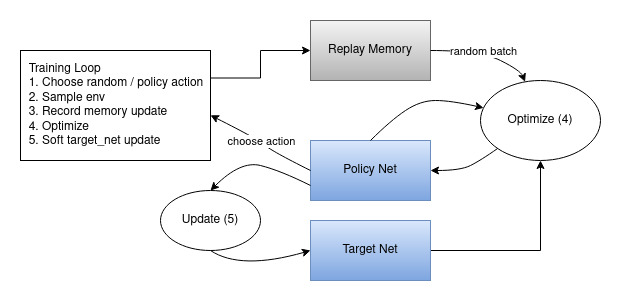

Figure 1. Deep Q-Learning algorithm workflow diagram (PyTorch, 2024).


##### **Key components**

1. **Initialisation**:

The agent is initialised with several key parameters:

- `state_size`: the size of the state space, which includes the agent location, item location, target location, relative directions and possession status.

- `action_size`: the number of possible actions, e.g., move north, south, west and east.

- `gamma`: the discount factor, which controls the importance and relevance of the future rewards.

- `epsilon`: the exploration rate, determining the probability of choosing a random action.

- `epsilon_decay`: the rate at which the exploration rate decays after each episode.

- `min_epsion`: the minimum value for the exploration rate.

- `replay_buffer_size`: the size of the replay buffer used to store past experience.

- `batch_size`: the size of the mini-batch sampled from the replay buffer during training.

- `lr`: the learning rate for the optimizer.

- `copy_freq`: the frequency with which the target network is updated.

Importantly, the agent has two neural networks, namely the prediction network, which is used to choose actions during training and the target network, which is used to compute the target Q-value. The target network is a copy of the prediction network and is periodically updated to stablise training.

2. **Neural network preparation**:

The funciton `prepare_torch` constructs the neural networks using PyTorch. The network is a simple feed-forward neural network with two hidden layers of 150 and 100 neurons, both followed by ReLU activation functions. The output layer has a size equal to the action space (i.e., move north, south, west, east). The agent uses two networks:

- `model`: the main Q-network that is updated during training.
- `model2`: the target network, which is a copy of `model` and is updated periodically.

The loss function is the mean squared error (MSE) and the optimizer is Adam.

3. **Action selection**

The function `get_action` is responsible for selecting actions using an $\epsilon$-greedy policy. With probability $\epsilon$, the agent selects a random action (exploration). Otherwise, the agent exploits its current knowledge by selecting the action with the maximum Q-value. The Q-values for the current state are obtained from the prediction network (`model`) by passing the state through the network and selecting the action with the maximum Q-value.

4. **Experience replay**

The agent uses a replay buffer to store past experiences in the form of tuples (state, action, reward, next_state, done). The function `remember` stores these experiences in the buffer. If the buffer exceeds its maximum capacity, the oldest experiences are removed.

During training, a mini-batch of experiences is randomly sampled from the replay buffer. This experience replay mechanism helps break correlations between consecutive experiences and stabilises learning.

5. **Q-value updates and training**

The agent's Q-values are updated during the training process using two key functions: `train_one_step` and `train`.

- Mini-batch sampling and target calculation

The `train` function handles the overall training process for the agent. When the replay buffer contains enough experiences (i.e., at least `batch_size`), a mini-batch of transitions (state, action, reward, next state, and done flag) is sampled from the buffer. For each transition in the mini-batch, the agent computes the target Q-value. If the next state is terminal, the target Q-value is set to the immediate reward. Otherwise, the target Q-value is calculated as:

\begin{equation}
target = R + \gamma \max\limits_{A'} Q(S', A')，
\end{equation}

where $R$ is the reward, $\gamma$ is the discount factor, and $Q(S', A')$ is the maximum predicted Q-value for the next state $S'$.

- Backpropagation and optimisation

Once the targets are computed, the `train_one_step` function is used to update the Q-values. This function calculates the loss as the difference between the predicted Q-values (from the prediction network) and the target Q-values (calculated from the target network). Using backpropagation, the agent minimises this loss with the Adam optimizer, adjusting the weights of the prediction network to better approximate the Q-values.

- Target network update

The target network is updated periodically every `copy_freq` steps (with a default of 100). This ensures that the target Q-values used for training remain stable for a certain period, helping to prevent oscillations or divergence in the learning process. The target network is updated by copying the weights from the prediction network using the `update_target()` function. This decoupling of the prediction and target networks improves training stability and is a key feature of Deep Q-Learning.

Together, these two functions ensure that the agent's Q-values are updated in a stable and efficient manner, allowing it to learn an optimal policy for the task over time.

6. **Exploration rate decay**

The function `decay_epsilon` gradually decreases the exploration rate $\epsilon$ after each episode. The rate decays multiplicatively by the factor `epsilon_decay`, and it is clamped to a minimum value `min_epsilon`. This allows the agent to transition from exploration to exploitation as it gains more knowledge of the environment.

The DQL algorithm implemented in the `DeepQAgent` class enables the agent to efficiently learn the optimal policy for completing the transport task in the grid world environment. Through the use of neural networks to approximate Q-values, the agent is able to handle larger and more complex state spaces than the table-based Q-learning algorithm. The combination of experience replay, target networks, and exploration decay allows the agent to balance exploration and exploitation, improving the stability and efficiency of learning.

In [4]:
# Implement the Deep Q-Learning algorithm
class DeepQAgent:
	# Initialise the agent with the state size, action size, and other hyperparameters
	def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0, epsilon_decay=0.995,
                 min_epsilon=0.1, replay_buffer_size=1000, batch_size=200, lr=0.001, copy_freq=100):
		# Initialise parameters
		self.state_size = state_size  # State size
		self.action_size = action_size  # Number of possible actions
		self.gamma = gamma  # Discount factor
		self.epsilon = epsilon  # Exploration rate
		self.epsilon_decay = epsilon_decay  # Decay factor for epsilon
		self.min_epsilon = min_epsilon  # Minimum epsilon for exploration
		self.batch_size = batch_size  # Mini-batch size for training
		self.lr = lr  # Learning rate for the optimizer
		self.copy_freq = copy_freq  # Frequency to update the target network

		# Step counter for updating the target network
		self.steps = 0

		# Experience replay buffer
		self.replay_buffer = []
		self.replay_buffer_size = replay_buffer_size

		# Initialise the Q-networks (prediction and target)
		self.model, self.model2, self.optimizer, self.loss_fn = self.prepare_torch()

	# Prepare the neural network model using PyTorch
	def prepare_torch(self):
		model = torch.nn.Sequential(
            torch.nn.Linear(self.state_size, 150),
            torch.nn.ReLU(),
            torch.nn.Linear(150, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, self.action_size)
        )
		model2 = copy.deepcopy(model)  # Target network is a copy of the prediction network
		model2.load_state_dict(model.state_dict())

        # Define loss function and optimizer with the given learning rate
		loss_fn = torch.nn.MSELoss()
		optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)

		return model, model2, optimizer, loss_fn

	# Update the target network with the prediction network
	def update_target(self):
		self.model2.load_state_dict(self.model.state_dict())

	# Get the Q-values for a given state
	def get_qvals(self, state):
		state_tensor = torch.from_numpy(state).float().unsqueeze(0)  # Unsqueeze to add batch dimension
		qvals_torch = self.model(state_tensor)
		return qvals_torch.detach().numpy()

	# Get the maximum Q-value for a given state
	def get_maxQ(self, next_state):
		state_tensor = torch.from_numpy(next_state).float().unsqueeze(0)  # Unsqueeze to add batch dimension
		return torch.max(self.model2(state_tensor)).item()

	# Get the action based on the epsilon-greedy policy
	def get_action(self, state):
		if random.uniform(0, 1) < self.epsilon:
			return random.choice([0, 1, 2, 3])  # Exploration with a random action
		else:
			qvals = self.get_qvals(state)
			return np.argmax(qvals)  # Exploitation with the best action based on Q-values

	# Store the experience in the replay buffer
	def remember(self, state, action, reward, next_state, done):
		self.replay_buffer.append((state, action, reward, next_state, done))
		if len(self.replay_buffer) > self.replay_buffer_size:
			self.replay_buffer.pop(0)

    # Optimised train_one_step function
	def train_one_step(self, states, actions, targets):
		# Convert lists of NumPy arrays to a single NumPy array
		states = np.array(states)
		actions = np.array(actions)
		targets = np.array(targets)

		# Convert data to tensors
		state_batch = torch.tensor(states, dtype=torch.float32)
		action_batch = torch.tensor(actions, dtype=torch.long)
		target_batch = torch.tensor(targets, dtype=torch.float32)

		# Get Q-values from the model for the current states
		qvals = self.model(state_batch)
		predicted_qvals = qvals.gather(1, action_batch.unsqueeze(1)).squeeze()

		# Compute the loss (TD error)
		loss = self.loss_fn(predicted_qvals, target_batch)

		# Backpropagation and optimisation step
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()

		return loss.item()

	# Train the agent using the experience replay buffer
	def train(self):
		# Wait until we have enough samples for a full mini-batch
		if len(self.replay_buffer) < self.batch_size:
			return
        
        # Sample a mini-batch from the replay buffer
		minibatch = random.sample(self.replay_buffer, self.batch_size)
		states, actions, rewards, next_states, dones = zip(*minibatch)

        # Compute TD-targets for each transition in the mini-batch
		targets = []
		for i in range(len(minibatch)):
			# If the episode has ended, the target is the reward otherwise the reward plus the discounted maximum Q-value
			if dones[i]:
				target = rewards[i]
			else:
				next_maxQ = self.get_maxQ(next_states[i])
				target = rewards[i] + self.gamma * next_maxQ
			targets.append(target)

		# Perform training on the mini-batch
		loss = self.train_one_step(states, actions, targets)

		# Update the target network every 'copy_freq' steps
		self.steps += 1
		if self.steps % self.copy_freq == 0:
			self.update_target()

		return loss

	# Decay the epsilon value after each episode
	def decay_epsilon(self):
		self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

***

### 4. Training Phase

The training process is implemented in the function `train_agent`, which trains the agent over a default of 1000 episodes. This DQL implementation leverages a neural network to approximate Q-values, enhancing the agent's ability to learn in more complex environments compared to traditional tabular Q-learning.

##### **Key components**

1. **Episode initialisation**:

At the start of each episode, the environment is reset using the `env.reset()` method, which randomises the initial agent, item, and target locations. The reset method returns the initial state of the environment. A boolean variable `done` is initialised to `False`, indicating that the episode is not yet finished. Additionally, a step counter (`steps`) is set to 0 to track the number of actions taken by the agent within the episode.

2. **Agent-environment interaction**:

Within each episode, the agent interacts with the environment by selecting actions and observing their effects. The loop continues until either the task is completed (i.e., the item is delivered to the target location) or the maximum allowed number of steps (`max_steps`, defaulted to 50) is reached.

The `max_steps` limit is set to prevent excessively long episodes, which could hinder efficient training. Episodes that exceed 50 steps are likely inefficient, so the task is considered failed if the agent cannot deliver the item within the limit. This encourages the agent to adopt efficient strategies and helps optimise training time by focusing on episodes with meaningful progress.

The agent selects an action using the `agent.get_action(state)` method, which follows an $\epsilon$-greedy policy. This policy balances exploration (random action selection) and exploitation (choosing the action with the maximum predicted Q-value based on the current state). The selected action is executed in the environment using `env.step(action)`, which returns the next state, the reward, and whether the episode is done.

3. **Q-value update**:

After each action, the agent stores the transition (state, action, reward, next state, done) in its experience replay buffer using the `agent.remember(state, action, reward, next_state, done)` method. Once the replay buffer has enough samples (i.e., it contains at least `batch_size` experiences), the agent samples a mini-batch from the buffer and trains its neural network by updating the predicted Q-values using the `agent.train()` method.

The training step minimises the difference between the predicted Q-values and the target Q-values (calculated using the target network). Backpropagation is applied to update the weights in the prediction network, improving the agent’s decision-making over time.

4. **Target network update**:

To stabilise learning, the agent updates its target network every `copy_freq` steps by copying the weights from the prediction network using the `agent.update_target()` method. This technique reduces the risk of oscillations during training by preventing the target values from changing too frequently.

5. **Exploration rate decay**:

After each episode, the agent’s exploration rate $\epsilon$ is decayed using the `agent.decay_epsilon()` method. This ensures that as training progresses, the agent transitions from exploration (trying new actions) to exploitation (using its learned policy). The decay factor is controlled by the `epsilon_decay` parameter, and the exploration rate is capped at a minimum value `min_epsilon`, ensuring some level of exploration is maintained throughout training.

6. **Episode termination**:

An episode can terminate either when the agent successfully delivers the item to the target location, or when the step count reaches `max_steps` (defaulted to 50). If the agent does not complete the task within the step limit, the episode ends without any additional penalties, and the agent moves to the next episode.

7. **Progress monitoring**:

The training process is monitored by printing progress updates every 100 episodes or at the end of training, based on the `verbose` parameter. The updates include the episode number, the time elapsed since the last update, and the current exploration rate $\epsilon$. This allows for real-time tracking of the agent’s training progress and the decay of its exploration rate over time, providing insights into its learning efficiency.

In [5]:
# Implement the training function for the agent
def train_agent(agent, env, episodes=1000, max_steps=50, verbose=True):
    # record the start time
    start_time = time.time()
    
	# Iterate over episodes to train the agent
    for episode in range(episodes):
        # Reset the environment for each new episode
        state = env.reset()
        done = False
        total_loss = 0
        steps = 0

        # Agent continues until the task is finished or the step limit is reached
        # No penalty for exceeding the step limit, just terminate the episode as it is not a successful one
        while not done and steps < max_steps:
            action = agent.get_action(state)  # Agent chooses an action
            next_state, reward, done = env.step(action)  # Execute the action in the environment
            
            # Store the experience in the replay buffer
            agent.remember(state, action, reward, next_state, done)
            
            # Perform training if enough samples are available in the replay buffer
            # Target network is updated every 'copy_freq' steps in the agent.train() function
            if len(agent.replay_buffer) >= agent.batch_size:
                loss = agent.train()
                total_loss += loss
            
            # Update to the next state
            state = next_state
            steps += 1
        
        # Decay the exploration rate after each episode
        agent.decay_epsilon()

        # Print progress
        if verbose and (episode + 1) % 100 == 0 or episode == episodes - 1:
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f'Episode {episode + 1}/{episodes} completed ({elapsed_time:.2f}s), epsilon: {agent.epsilon:.3f}')
            start_time = time.time()

***

### 5. Evaluation Phase


#### **Introduction**
In this project, our goal is to implement a DQL algorithm to enable an agent to effectively complete a specified task in a grid world environment. The agent's task is to start from a random position, pick up an item located at point A, and deliver it to point B. To evaluate the agent's learning and generalisation abilities, we designed two tests: the first test assesses the model's performance with different numbers of training episodes, the second test evaluates the performance of a model trained extensively across all possible initial states.

Our objectives in conducting these tests are as follows:

##### **1. Verifying the model's learning ability**
- **Objective**: Through the first test, we can verify the model's learning ability under different training conditions. Theoretically, as the number of training episodes increases, the model should be able to better learn the optimal strategy for completing the task.

- **Expected outcome**: By analysing the success rate, average steps, average reward, and deviation from the optimal strategy, we can verify whether increasing the training episodes indeed leads to improved performance. If the test results show improvement in these metrics as the number of training episodes increases, it indicates that the model's learning ability has been enhanced.

##### **2. Verifying the model's generalisation ability**
- **Objective**: Through the second test, we can verify the performance of the trained model under different initial conditions.

- **Expected outcome**: If the test results show that the model maintains a high success rate and low average steps and deviation under all possible initial states, it indicates that the model has strong generalisation ability. This means that the model not only performs well under specific training conditions but can also effectively complete tasks in varying environments.

**Please note that epsilon is set to 0 in the testing phase** to ensure that the agent performs only exploitation based on its learned policy, without any exploration. This allows for evaluating how well the agent has learned the task by executing the optimal actions according to its Q-values, without taking random exploratory actions. This setting is crucial for assessing the agent's performance after training.

In [6]:
# Function to calculate the Manhattan distance between two points, used to calculate the optimal steps
def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Function to test the agent in the environment for a certain number of episodes (default 100 random episodes)
def test_agent(agent, env, episodes=100, max_steps=50, step_verbose=True):
    # Save the original epsilon value
    original_epsilon = agent.epsilon
    # Set epsilon to 0 to turn off exploration during testing
    agent.epsilon = 0

    # Initialise metrics to calculate overall performance
    success_count = 0.0
    total_steps = 0.0
    total_reward = 0.0
    total_deviation = 0.0
    total_deviation_rate = 0.0

    # Test the agent for the specified number of episodes
    for episode in range(episodes):
        # Reset the environment for each new episode
        state = env.reset()
        done = False
        episode_steps = 0
        episode_reward = 0

        # Initial positions are extracted from the state vector considering the new structure
        initial_agent_location = state[:2]  # Agent's (y,x) position
        initial_item_location = state[2:4]  # Item's (y,x) position
        drop_off_location = state[4:6]  # Target's (y,x) position

        # Calculate theoretical shortest path or optimal steps
        optimal_steps_to_item = manhattan_distance(initial_agent_location, initial_item_location)
        optimal_steps_to_target = manhattan_distance(initial_item_location, drop_off_location)
        optimal_steps = optimal_steps_to_item + optimal_steps_to_target

        if step_verbose:
            print(f"\n--- Episode {episode + 1} ---")
            print(f"Initial Agent Location: {initial_agent_location}")
            print(f"Initial Item Location (A): {initial_item_location}")
            print(f"Drop-Off Location (B): {drop_off_location}")

        # Agent continues until the task is finished or the step limit is reached
        while not done and episode_steps < max_steps:
            action = agent.get_action(state)  # Agent selects an action (0: north, 1: south, 2: west, 3: east)
            next_state, reward, done = env.step(action)  # Execute the action in the environment
            
            episode_steps += 1
            episode_reward += reward
            state = next_state

            if step_verbose:
                # Translate the action back to readable directions
                action_str = ['north', 'south', 'west', 'east'][action]
                # Print the step details
                print(f"Step {episode_steps}: Action = {action_str}, Reward = {reward}, New State = {next_state}")

        # Calculate the deviation from the optimal steps, total deviation, total steps, and total reward
        deviation = episode_steps - optimal_steps
        deviation_rate = deviation / optimal_steps 
        total_deviation += deviation
        total_deviation_rate += deviation_rate
        total_steps += episode_steps
        total_reward += episode_reward

        # Count the number of successful episodes where the agent delivers the item to the target location
        if done and np.array_equal(state[:2], drop_off_location) and state[-1] == 1:
            success_count += 1

        if step_verbose:
            # Print the summary of the episode
            print(f"Episode {episode + 1} Summary: Steps = {episode_steps} (Optimal Steps = {optimal_steps}), Total Reward = {episode_reward}, Deviation from Optimal: {deviation}")

    # Restore the original epsilon value after testing
    agent.epsilon = original_epsilon

    # Calculate final metrics
    success_rate = success_count / episodes
    average_steps = total_steps / episodes
    average_reward = total_reward / episodes
    average_reward_per_step = total_reward / total_steps / episodes
    average_deviation = total_deviation / episodes
    average_deviation_rate = total_deviation_rate / episodes

    if step_verbose:
        # Print the overall metrics after all test episodes
        print("\n--- Overall Performance Metrics ---")
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Steps to Completion: {average_steps:.2f}')
        print(f'Average Reward: {average_reward:.2f}')
        print(f'Average Reward per Step: {average_reward_per_step:.2f}')
        print(f'Average Deviation from Optimal: {average_deviation:.2f}')
        print(f'Average Deviation Rate: {average_deviation_rate:.2f}%')

    return {
        'success_rate': success_rate * 100,
        'average_steps': average_steps,
        'average_reward': average_reward,
        'average_deviation_rate': average_deviation_rate
    }


#### **Test 1: Evaluating model performance with different training episodes**
To evaluate how the number of training episodes affects model performance, we designed and conducted the following experiment:

##### **Code implementation**
In this experiment, we set different numbers of training episodes, including 100, 200, 300, 400, 500, 750, 1000 episodes. We then conducted 100 tests for each model and repeated each experiment 5 times, calculating the mean and standard deviation of the following metrics:

- **Success Rate**: The success rate indicates the percentage of trials where the agent successfully completes the task, usually expressed as a percentage. It reflects the overall effectiveness of the model.

- **Average Steps**: Average steps represent the number of steps the agent takes to complete the task from the initial position. This metric reflects the efficiency of the agent in executing the task — the fewer steps, the better the path found by the agent.

- **Average Reward**: Average reward represents the total average reward the agent accumulates during the task. This metric reflects the effectiveness of the agent's strategy, with higher rewards indicating more effective behaviour.

- **Average Deviation Rate from Optimal**: This metric represents the average difference between the agent's actual path and the theoretically optimal path, reflecting the optimisation of the agent's strategy. The smaller the deviation, the closer the agent's strategy is to the optimal solution. The calculation formula is given as

\begin{equation*}
\frac{{\text{actual steps} - \text{optimal steps}}}{{\text{optimal steps}}}.
\end{equation*}

By plotting these metrics against the number of training episodes, we can visually observe the impact of training episodes on model performance.



##### **Explanation**

1. The reason for introducing the "Average Deviation Rate from Optimal" metric is that the other three metrics have their own limitations. The Success Rate does not adequately reflect the intelligence of the agent. Due to varying initial states, both Average Steps and Average Reward can also show inconsistencies. Therefore, we designed the Average Deviation Rate from Optimal metric, expressed as a ratio, to capture the degree of deviation between the agent’s actions and the optimal actions. This metric provides a better reflection of the agent’s intelligence.

2. In a single epoch, we conducted multiple tests (test_episodes) and repeated the training and testing across multiple epochs (num_repeats). This approach was taken to minimise the impact of random initial states on the results and to more accurately measure how the model’s performance trends with training.

3. One possible testing method is to use a fixed initial state to compare the metrics corresponding to different training levels (training episodes). However, after careful consideration, we discontinued this approach because it only reflects changes in the model under a single initial state, which differs from our actual requirement for the model (i.e., solving the task independently of the location of A).

In [ ]:
# Set a step limit (e.g., adjusted to 50 for a 4x4 grid, calculated based on the grid and task complexity)
STEP_LIMIT = 50

training_episodes_list = [100, 200, 300, 400, 500, 750, 1000]
test_episodes = 100
num_repeats = 5  # Use 5 for more robust statistics

# Set up the environment
env = GridWorld(size=4)  # Ensure this matches your GridWorld's setup

# Dictionary to store results
results = {
    'training_episodes': [],
    'success_rate_mean': [],
    'success_rate_std': [],
    'average_steps_mean': [],
    'average_steps_std': [],
    'average_reward_mean': [],
    'average_reward_std': [],
    'average_deviation_rate_mean': [],
    'average_deviation_rate_std': []
}

# Run the experiment for different training episodes
for training_episodes in training_episodes_list:
    print(f"\n--- Training with {training_episodes} Episodes ---")
    success_rates = []
    average_steps = []
    average_rewards = []
    average_deviations = []
    
    # Repeat the experiment for each training episode
    for _ in range(num_repeats):
        print(f"\n--- Repeat {_ + 1} ---")
        # Reinitialize the agent for each training run
        state_size = 11  # Example: (y, x) for agent, item, target, directions to item and target, and has_item
        action_size = 4  # ['north', 'south', 'west', 'east']
        agent = DeepQAgent(state_size=state_size, action_size=action_size)
        
        # Train the agent
        train_agent(agent, env, training_episodes, max_steps=STEP_LIMIT)
        
        # Test the agent
        metrics = test_agent(agent, env, episodes=test_episodes, max_steps=STEP_LIMIT, step_verbose=False)
        
        # Store individual test results
        success_rates.append(metrics['success_rate'])
        average_steps.append(metrics['average_steps'])
        average_rewards.append(metrics['average_reward'])
        average_deviations.append(metrics['average_deviation_rate'])
    
    # Store mean and standard deviation of results
    results['training_episodes'].append(training_episodes)
    results['success_rate_mean'].append(np.mean(success_rates))
    results['success_rate_std'].append(np.std(success_rates))
    results['average_steps_mean'].append(np.mean(average_steps))
    results['average_steps_std'].append(np.std(average_steps))
    results['average_reward_mean'].append(np.mean(average_rewards))
    results['average_reward_std'].append(np.std(average_rewards))
    results['average_deviation_rate_mean'].append(np.mean(average_deviations))
    results['average_deviation_rate_std'].append(np.std(average_deviations))

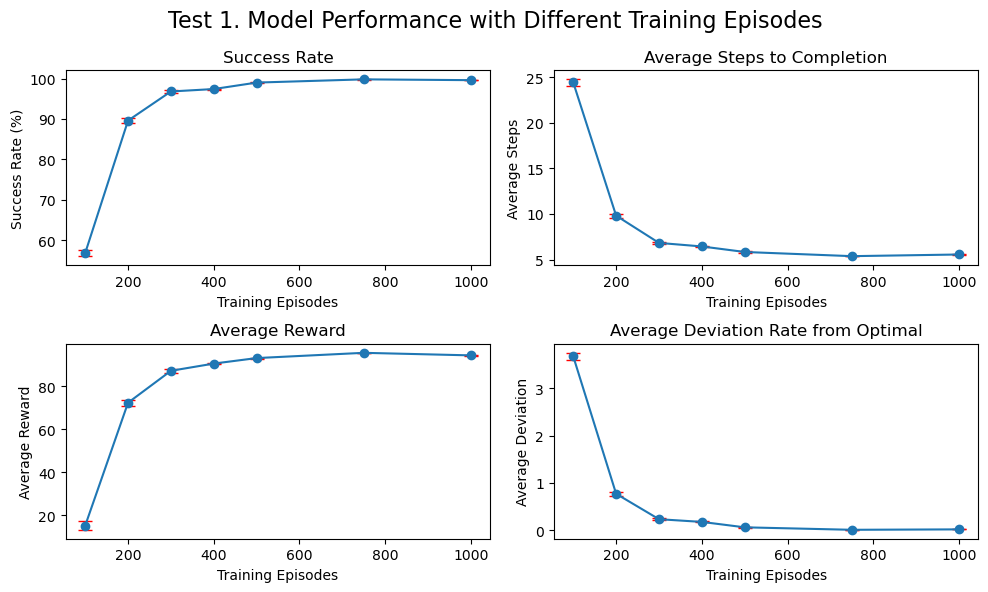

In [9]:
# Plotting results with error bars
plt.figure(figsize=(10, 6))
plt.suptitle('Test 1. Model Performance with Different Training Episodes', fontsize=16)

plt.subplot(2, 2, 1)
plt.errorbar(results['training_episodes'], results['success_rate_mean'], 
             yerr=np.array(results['success_rate_std']) * 0.1, fmt='-o', ecolor='red', capsize=5)
plt.title('Success Rate')
plt.xlabel('Training Episodes')
plt.ylabel('Success Rate (%)')

plt.subplot(2, 2, 2)
plt.errorbar(results['training_episodes'], results['average_steps_mean'], 
             yerr=np.array(results['average_steps_std']) * 0.1, fmt='-o', ecolor='red', capsize=5)
plt.title('Average Steps to Completion')
plt.xlabel('Training Episodes')
plt.ylabel('Average Steps')

plt.subplot(2, 2, 3)
plt.errorbar(results['training_episodes'], results['average_reward_mean'], 
             yerr=np.array(results['average_reward_std']) * 0.1, fmt='-o', ecolor='red', capsize=5)
plt.title('Average Reward')
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward')

plt.subplot(2, 2, 4)
plt.errorbar(results['training_episodes'], results['average_deviation_rate_mean'], 
             yerr=np.array(results['average_deviation_rate_std']) * 0.1, fmt='-o', ecolor='red', capsize=5)
plt.title('Average Deviation Rate from Optimal')
plt.xlabel('Training Episodes')
plt.ylabel('Average Deviation')

plt.tight_layout()
plt.show()

In [10]:
print("success_rate_mean:", [round(value, 2) for value in results['success_rate_mean']])
print("average_steps_mean:", [round(value, 2) for value in results['average_steps_mean']])
print("average_reward_mean:", [round(value, 2) for value in results['average_reward_mean']])
print("average_deviation_rate_mean:", [round(value, 2) for value in results['average_deviation_rate_mean']])


success_rate_mean: [56.8, 89.6, 96.8, 97.4, 99.0, 99.8, 99.6]
average_steps_mean: [24.4, 9.81, 6.82, 6.43, 5.83, 5.37, 5.55]
average_reward_mean: [15.28, 72.29, 87.09, 90.44, 92.99, 95.43, 94.24]
average_deviation_rate_mean: [3.68, 0.77, 0.23, 0.18, 0.06, 0.01, 0.02]


Based on the experimental results, the impact of different training episodes on the model’s performance can be explained and analysed as follows:

### **Conclusion Analysis:**

- **Success Rate**

  As the number of training episodes increases, the success rate improves from 56.8% at 100 episodes to 99.6% at 1000 episodes. The success rate stabilises after 400 episodes, reaching close to 100%, indicating that the model can successfully complete tasks in almost all test scenarios after sufficient training.

- **Average Steps**

	The average number of steps decreases significantly as training episodes increase, dropping from 24.4 steps at 100 episodes to 5.55 steps at 1000 episodes. In particular, there is a sharp decline in steps between 100 and 300 episodes, indicating that the model gradually learns to plan more efficient paths. After 400 episodes, the average steps become stable, showing that the model has matured in its strategy and its ability to find optimal paths has stabilised.

- **Average Reward**

	The average reward increases from 15.28 at 100 episodes to 94.24 at 1000 episodes, demonstrating the model’s increasing effectiveness. Once training reaches 400 episodes or more, the average reward stabilises above 90, indicating that the model has found a good balance between strategy optimisation and task execution.

- **Average Deviation Rate from Optimal**

  This metric decreases significantly, from 3.68 at 100 episodes to 0.02 at 1000 episodes. This shows that as training progresses, the model's decisions become increasingly close to the optimal path, with deviations becoming almost negligible. The deviation rate approaches to 0 after 400 episodes, suggesting that the model has learned a more efficient strategy by this point.

### **Overall Conclusion**:

From these results, it can be concluded that as the number of training episodes increases, the model’s performance improves significantly, especially in the early stages (100-300 episodes), where the most notable improvements in success rate and average steps occur. After 400 episodes, performance gradually stabilises, with little change in success rate, average steps, and rewards, indicating that the model is approaching an optimal state. The significant decrease in deviation rate further confirms the maturity and optimisation of the model's strategy.

Therefore, increasing the number of training episodes significantly enhances the model's performance, but after 400-500 episodes, the additional training yields diminishing returns in terms of performance improvement.

In addition to the metrics above, we also monitored the training loss during the learning process. After approximately 400 episodes, the training loss approaches 0, further verifying the convergence of the deep-Q network. This indicates that the agent's Q-value predictions have become more accurate, and the model has learned an optimal or near-optimal policy. The convergence of the loss function, along with the stabilisation of success rate, average steps, and rewards, confirms that the model has effectively learned to complete the task efficiently.

### **Test 2: Evaluating the performance of a model trained extensively across all initial states**
In the second test, we selected a model trained with 5000 episodes and evaluated its performance across all possible initial states. Specifically, we traversed all possible combinations of the agent's initial position, the item's position and the target's position (approximately $16^3$ = 4096 cases), measuring the model's performance in these scenarios.

#### **Code implementation**
To cover all possible initial states, we traversed each possible agent starting position and item position in a $4\times4$ grid and conducted 100 tests for each state. We recorded the success rate, average steps, average reward, and deviation rate from the optimal strategy, and the corresponding means and standard deviations are provided. It is worth pointing out that we exclude cases where the initial item position is the same as the initial agent position, and the initial item position is the same as the target location according to the assumptions.

#### **Capability assessment**
The purpose of this test is to evaluate whether the model, after extensive training, can perform well across all initial states. This is crucial for assessing the model's generalisation ability: whether it can successfully complete the task and achieve high rewards regardless of the initial conditions.


In [11]:
# Training parameters
training_episodes = 5000  # Number of training episodes
test_episodes = 100  # Number of test episodes per configuration
num_repeats = 5  # Number of repeats per initial configuration

# Grid size
grid_size = 4

# Initialize the environment
env = GridWorld(size=grid_size)

# Initialize the Deep Q-learning agent
# State size now includes agent, item, target (y,x), directions (to item and target), and possession status
state_size = 11  # 2 for agent (y,x), 2 for item (y,x), 2 for target (y,x), 4 for directions, 1 for possession status
action_size = 4  # Four possible actions (north, south, west, east)
agent = DeepQAgent(state_size=state_size, action_size=action_size)

# Train the agent
train_agent(agent, env, training_episodes)

# Initialize dictionaries to store results
results = {
    'initial_states': [],
    'success_rate_mean': [],
    'success_rate_std': [],
    'average_steps_mean': [],
    'average_steps_std': [],
    'average_reward_mean': [],
    'average_reward_std': [],
    'average_deviation_rate_mean': [],
    'average_deviation_rate_std': []
}

# Iterate over all possible initial states (agent start position, item position and target position)
for start_x in range(grid_size):
	for start_y in range(grid_size):
		for item_x in range(grid_size):
			for item_y in range(grid_size):
				for target_x in range(grid_size):
					for target_y in range(grid_size):
						success_rates = []
						average_steps = []
						average_rewards = []
						average_deviations = []

						initial_agent_pos = (start_x, start_y)
						initial_item_pos = (item_x, item_y)
						initial_target_pos = (target_x, target_y)
						if  initial_item_pos == initial_agent_pos:
							continue
						if initial_item_pos == initial_target_pos:
							continue

            			# Repeat the test multiple times for each initial state
						for _ in range(num_repeats):
							# Reinitialise the environment with the given agent and item positions
							# preset_agent_location=(4, 0), preset_item_location=(0, 4), preset_target_location=(4,4)
							env = GridWorld(size=grid_size, preset_agent_location=initial_agent_pos, preset_item_location=initial_item_pos, preset_target_location=initial_target_pos, given_location=True)
							metrics = test_agent(agent, env, episodes=test_episodes, step_verbose=False)

							# Store individual test results
							success_rates.append(metrics['success_rate'])
							average_steps.append(metrics['average_steps'])
							average_rewards.append(metrics['average_reward'])
							average_deviations.append(metrics['average_deviation_rate'])

							# Store the mean and standard deviation of results
							results['success_rate_mean'].append(np.mean(success_rates))
							results['success_rate_std'].append(np.std(success_rates))
							results['average_steps_mean'].append(np.mean(average_steps))
							results['average_steps_std'].append(np.std(average_steps))
							results['average_reward_mean'].append(np.mean(average_rewards))
							results['average_reward_std'].append(np.std(average_rewards))
							results['average_deviation_rate_mean'].append(np.mean(average_deviations))
							results['average_deviation_rate_std'].append(np.std(average_deviations))

# Print final summary
print(f"\n--- Final Summary over {num_repeats} Repeats of {test_episodes} Test Episodes ---")
print(f"success_rate: {np.mean(results['success_rate_mean']).round(2)} +/- {np.mean(results['success_rate_std']).round(2)}")
print(f"average_steps: {np.mean(results['average_steps_mean']).round(2)} +/- {np.mean(results['average_steps_std']).round(2)}")
print(f"average_reward: {np.mean(results['average_reward_mean']).round(2)} +/- {np.mean(results['average_reward_std']).round(2)}")
print(f"average_deviation_rate: {np.mean(results['average_deviation_rate_mean']).round(2)} +/- {np.mean(results['average_deviation_rate_std']).round(2)}")

Episode 100/5000 completed (164.30s), epsilon: 0.606
Episode 200/5000 completed (72.04s), epsilon: 0.367
Episode 300/5000 completed (45.46s), epsilon: 0.222
Episode 400/5000 completed (32.24s), epsilon: 0.135
Episode 500/5000 completed (26.09s), epsilon: 0.100
Episode 600/5000 completed (29.48s), epsilon: 0.100
Episode 700/5000 completed (29.91s), epsilon: 0.100
Episode 800/5000 completed (26.99s), epsilon: 0.100
Episode 900/5000 completed (26.94s), epsilon: 0.100
Episode 1000/5000 completed (29.10s), epsilon: 0.100
Episode 1100/5000 completed (27.57s), epsilon: 0.100
Episode 1200/5000 completed (27.26s), epsilon: 0.100
Episode 1300/5000 completed (28.05s), epsilon: 0.100
Episode 1400/5000 completed (31.64s), epsilon: 0.100
Episode 1500/5000 completed (27.30s), epsilon: 0.100
Episode 1600/5000 completed (27.04s), epsilon: 0.100
Episode 1700/5000 completed (28.60s), epsilon: 0.100
Episode 1800/5000 completed (26.63s), epsilon: 0.100
Episode 1900/5000 completed (25.65s), epsilon: 0.100
E

In this evaluation of the Deep-Q learning model, after 5000 episodes of training, its performance was tested and analysed across all possible initial states. Specifically, the test measured the model's performance by traversing each possible combination of the agent's, item's, and target's starting positions in a $4\times4$ grid, calculating success rate, average steps, average reward, and deviation from the optimal strategy.

### **Result Analysis:**
- **Success Rate: 100.0 +/- 0.0**  

  The model successfully completed tasks in almost all initial states, with a success rate of 100%. This indicates that the model, after extensive training, can generalise very well and consistently execute tasks regardless of initial conditions.

- **Average Steps: 5.33 +/- 0.11**  

  The average number of steps is approximately 5, indicating that the model can efficiently find solutions. The low standard deviation shows the stability of its strategy.

- **Average Reward: 95.67 +/- 0.11**  

  The average reward is very close to the maximum score across all initial states, meaning the model not only completes the task successfully but also maximises its rewards, demonstrating its ability to follow a near-optimal strategy.

- **Average Deviation Rate: 0.0 +/- 0.0** 

  The average deviation rate is 0, showing that the model’s performance is optimal. This further verifies that the model effectively follows optimal strategies even across a wide range of initial states.

### **Conclusion:**

This test concludes that after 5000 episodes of training, the model not only maintains near-perfect performance across diverse initial states but also demonstrates high generalisation capability and stability. The success rate and rewards are almost maximal, while the number of steps and deviation rate remain low, showcasing the Deep-Q model's exceptional performance in handling complex tasks and varied scenarios.

***

### 6. Visualisation

The visualisation phase is implemented using the `matplotlib` library with the `TkAgg` backend, allowing for interactive and animated representations of the agent's behaviour in the grid world environment. This visualisation aims to show the performance of agents with different levels of training, assess their generalisability, and visually present the learning progress.

##### **Key components**

1. **Environment initialisation**:

The `env.reset()` function initialises the environment for each new episode, randomly setting the initial positions of the agent and item, preparing for a new simulation. It also establishes initial values for `state`, `done`, `episode_steps`, and `episode_reward`.

2. **Initial setup**:

Initial agent, item and target positions are printed, which provides context for the observer and serves as a benchmark for evaluating the agent's performance. 

3. **Visualisation setup**:

Functions like `ListedColormap()`, `plt.subplots()`, `ax.set_xticks()`, `ax.set_yticks()`, and `ax.grid()` are used to create and configure the figure object. Custom color maps and grid lines are set up to enhance visual clarity. The legend explains different grid states:

- Letter `A` with Green backgroun: Agent
- Letter `I` with Red background: Item
- Letter `T` with Gray background: Target location
- Text `A+I` with Cyan background: Agent carrying the item
- Text `A at T (No I)` with Magenta backgroun: Agent at target location without the item
- Text `A+I at T` with Orange background: Agent at target location with the item

4. **Animation function**:

The internal function `animate(i)` updates each frame of the visualisation. It calls `agent.choose_action(state)` and `env.step(action)` to show the agent's real-time decision-making process. It uses `ax.imshow()` to update the grid state and `ax.text()` to add annotations for different elements (agent, item, target). The function employs complex conditional logic to update grid states, reflecting different scenarios (e.g., agent carrying item, reaching target). It also prints detailed step information for in-depth analysis.

5. **Animation creation and display**:

The visualisation process is implemented using `FuncAnimation()` to create an animated representation of the agent's behavior. This animation is displayed using `plt.show()`. To ensure the visualisation remains manageable and informative, we use a maximum step limit `(step_limit=25)`, which serves three crucial purposes:

- It prevents the visualisation from running indefinitely if the agent is stuck in a loop.
- It simulates real-world constraints where tasks often have time or resource limitations.
- It provides a clear metric for improvement: as training progresses, the agent should complete the task within this limit more consistently.

**Two possible scenarios:**<br>

1. Task Not Completed (Failure Case):

If the maximum step limit is reached without task completion:
A `red` text annotation appears on the plot: "Failed to complete within `step_limit` step limit!"

2. Task Completed Successfully:

A `blue` text annotation is added to the plot: "Successfully completed the task with deviation from the optimal path by `deviation` step(s)!"

After each visulisation, comprehensive summary is printed, detailing:

- Number of steps taken
- Optimal step count
- Total reward accumulated
- Deviation from the optimal path

In [7]:
# Function to visualise one episode using the trained agent with step limit
def visualise_episode(agent, env, cumulative_episodes, interval=500, step_limit=25):
    # Reset the environment to start a new episode
    state = env.reset()
    done = False
    episode_steps = 0
    episode_reward = 0

    # Capture initial positions for printing
    initial_agent_location = state[:2]
    initial_item_location = state[2:4]
    drop_off_location = state[4:6]

    # Calculate theoretical shortest path or optimal steps
    optimal_steps_to_item = manhattan_distance(initial_agent_location, initial_item_location)
    optimal_steps_to_target = manhattan_distance(initial_item_location, drop_off_location)
    optimal_steps = optimal_steps_to_item + optimal_steps_to_target
    
    # Print the initial locations and episode information
    print(f"Initial Agent Location: {initial_agent_location}")
    print(f"Initial Item Location (A): {initial_item_location}")
    print(f"Drop-Off Location (B): {drop_off_location}")

    # Define a custom colormap
    cmap = ListedColormap(['white', 'green', 'red', 'gray', 'cyan', 'magenta', 'orange'])

    # Create the figure for visualisation
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xticks(np.arange(-0.5, env.size, 1))
    ax.set_yticks(np.arange(-0.5, env.size, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, color='black')  # Set grid lines to black
    ax.set_aspect('equal')

    # Set the background color to white
    ax.set_facecolor('white')

    # Add a title to the figure
    fig.suptitle(f'Grid World - Trained {cumulative_episodes} Episodes', fontsize=16)

    # Define the legend patches
    legend_patches = [
        mpatches.Patch(color='green', label='A - Agent'),
        mpatches.Patch(color='red', label='I - Item'),
        mpatches.Patch(color='gray', label='T - Target'),
        mpatches.Patch(color='cyan', label='A+I'),
        mpatches.Patch(color='magenta', label='A at T (No I)'),
        mpatches.Patch(color='orange', label='A+I at T'),
    ]

    # Animate the grid world for each step in the episode
    def animate(i):
        # Access the nonlocal variables to update them
        nonlocal state, episode_steps, done, episode_reward

        # Display the initial state before starting the episode
        if i == 0:
            agent_pos, item_pos, has_item = state[:2], state[2:4], state[-1]

            grid = np.zeros((env.size, env.size))
            grid[tuple(agent_pos)] = 1
            grid[tuple(item_pos)] = 2
            grid[env.target_location] = 3

            ax.imshow(grid, cmap=cmap, vmin=0, vmax=6)

            # Annotate the grid with labels but no color changes
            for (j, i), label in np.ndenumerate(grid):
                if label == 1:  # Agent location only
                    ax.text(i, j, 'A', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 2:  # Item location only
                    ax.text(i, j, 'I', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 3:  # Target location only
                    ax.text(i, j, 'T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

            # Reapply the legend after clearing
            ax.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.36, 0.85), fontsize='11')

            return

        # Continue the episode if the task is not finished and step limit is not reached
        if not done and episode_steps < step_limit:
            # Select the action and perform the step in the environment
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)

            episode_steps += 1
            episode_reward += reward
            state = next_state

            # Create the grid to visualise
            grid = np.zeros((env.size, env.size))
            agent_pos, item_pos, has_item = next_state[:2], next_state[2:4], next_state[-1]

            # Update the grid colors based on the current state
            if not has_item and tuple(agent_pos) != env.target_location:
                grid[tuple(agent_pos)] = 1
                grid[tuple(item_pos)] = 2
                grid[env.target_location] = 3
            elif not has_item and tuple(agent_pos) == env.target_location:
                grid[tuple(item_pos)] = 2
                grid[env.target_location] = 5
            elif has_item and tuple(agent_pos) != env.target_location:
                grid[tuple(agent_pos)] = 4
                grid[env.target_location] = 3
            elif has_item and tuple(agent_pos) == env.target_location:
                grid[env.target_location] = 6

            ax.clear()
            ax.imshow(grid, cmap=cmap, vmin=0, vmax=6)

            # Reapply grid lines and labels after clearing
            ax.set_xticks(np.arange(-0.5, env.size, 1))
            ax.set_yticks(np.arange(-0.5, env.size, 1))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(True, color='black')  # Set grid lines to black
            ax.set_facecolor('white')  # Set background color to white

            # Annotate the grid with labels but no color changes
            for (j, i), label in np.ndenumerate(grid):
                if label == 1:  # Agent location only
                    ax.text(i, j, 'A', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 2:  # Item location only
                    ax.text(i, j, 'I', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 3:  # Target location only
                    ax.text(i, j, 'T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 4:  # Agent location with item
                    ax.text(i, j, 'A+I', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 5:  # Target location with agent but without item
                    ax.text(i, j, 'A at T (No I)', ha='center', va='center', color='black', fontsize=11, fontweight='bold')
                elif label == 6:  # Target location with agent and item
                    ax.text(i, j, 'A+I at T', ha='center', va='center', color='black', fontsize=11, fontweight='bold')

            # Reapply the legend after clearing
            ax.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.36, 0.85), fontsize='11')

        # Stop the animation if the task is finished or the maximum steps are reached
        if done or episode_steps == step_limit:
            deviation = episode_steps - optimal_steps
            if episode_steps == step_limit:
                print(f"*** After {cumulative_episodes} episodes of training, agent did not complete the task within {step_limit} steps.\n")
                # Annotate the "Failed" case on the plot
                ax.text(0.5, 0.5, f'Failed to complete within {step_limit} step limit !', 
                        ha='center', va='center', transform=ax.transAxes, 
                        fontsize=20, color='red', fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))
            elif done:
                # Print the summary of the episode
                # Annotate the "Successful" case on the plot
                ax.text(0.5, 0.5, f'Successfully completed the task with\n deviation from the optimal path by {deviation} step(s) !'.format(episode_steps),
                        ha='center', va='center', transform=ax.transAxes, 
                        fontsize=20, color='blue', fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'))
                print(f"*** After {cumulative_episodes} episodes of training, agent completed the task.")
                print(f"Summary: Steps = {episode_steps} (Optimal Steps = {optimal_steps}), Total Reward = {episode_reward}, Deviation from Optimal: {deviation}\n")

            anim.event_source.stop()  # Stop the animation when done
            plt.draw()  # Force a draw of the current figure to ensure the last frame is rendered

            plt.pause(2)  # Short pause to ensure the rendering occurs
            plt.close(fig)  # Automatically close the figure window

    # Create the animation
    anim = FuncAnimation(fig, animate, interval=interval, frames=100)

    plt.show()


In [8]:
# Visualise trained agent at different training levels with step limit

# training progression list, e.g. first train for 100 episodes, then an additional 100 episodes
# with a total of 200 episodes, then an additional 100 episodes with a total of 300 episodes, and so on
# This is equivalent to test an agent at different training levels of 100, 200, 300, 400, and 500 episodes.

episodes_progression_list = [100, 100, 100, 100, 100]
step_limit = 25  # Define the step limit based on the environment's size and constraints

# Initialise the environment and agent
env = GridWorld(size=4)
state_size = 11  # (y,x) for agent, item, target + directions + possession status
action_size = 4  # Four possible actions (north, south, west, east)
agent = DeepQAgent(state_size=state_size, action_size=action_size)
cumulative_episodes = 0

for episode in episodes_progression_list:
    cumulative_episodes += episode
    train_agent(agent, env, episode, max_steps=step_limit)  # Pass step_limit to the training function
    print(f"--- After {cumulative_episodes} Training Episodes Test Visualisation and Summary ---")
    
    visualise_episode(agent, env, cumulative_episodes, step_limit=step_limit)  # Pass step_limit to the visualisation function


Episode 100/100 completed (74.83s), epsilon: 0.606
--- After 100 Training Episodes Test Visualisation and Summary ---
Initial Agent Location: [2 3]
Initial Item Location (A): [2 0]
Drop-Off Location (B): [0 2]
*** After 100 episodes of training, agent completed the task.
Summary: Steps = 13 (Optimal Steps = 7), Total Reward = 88, Deviation from Optimal: 6

Episode 100/100 completed (66.85s), epsilon: 0.367
--- After 200 Training Episodes Test Visualisation and Summary ---
Initial Agent Location: [2 1]
Initial Item Location (A): [3 3]
Drop-Off Location (B): [2 0]
*** After 200 episodes of training, agent completed the task.
Summary: Steps = 11 (Optimal Steps = 7), Total Reward = 90, Deviation from Optimal: 4

Episode 100/100 completed (33.59s), epsilon: 0.222
--- After 300 Training Episodes Test Visualisation and Summary ---
Initial Agent Location: [1 3]
Initial Item Location (A): [2 1]
Drop-Off Location (B): [1 3]
*** After 300 episodes of training, agent completed the task.
Summary: S

**Examples of effects of different training episodes**

We use random initialisations for each test to evaluate the agent's ability to generalise. By randomly setting the initial positions of the agent, item and drop-off for each visualisation, we ensure that the agent's performance is tested across various scenarios, not just those it encountered during training. This approach helps assess whether the agent has learned general strategies or merely memorised specific paths.

As the number of training episodes increases, we observe a clear progression in the agent's performance:

- **Exploratory stage (~ 100 episodes)**:

By 100 episodes, the agent shows significant errors and sometimes fails to complete the task within the step limit. The movements are mostly exploratory, and the agent’s behavior is inefficient, indicating that the strategy is not yet developed.

- **Adaptive stage (~ 200 episodes)**:

By 200 episodes, the agent mostly completes the task, though some errors still occur. While the agent’s strategy is beginning to take shape, there are still deviations from the optimal path.

- **Proficient stage (~ 300 episodes)**:

By 300 episodes, the agent’s performance improves significantly, completing tasks more consistently with rare errors. The agent is more efficient and demonstrates a more reliable strategy in most scenarios.

- **Optimising stage (~ 400 episodes)**:

By 400 episodes, the agent’s performance continues to improve, with fewer errors and greater efficiency in task completion. The strategy becomes more refined, and the agent’s behavior is very close to optimal. The probability of errors is low, showing significant progress in learning with only occasional deviations from optimal performance.

- **Mastery stage (~ 500 episodes)**:

By 500 episodes, the agent’s performance is nearly flawless. The probability of errors is extremely low, and the agent consistently completes tasks across various scenarios with minimal deviations from the optimal strategy. The model has almost fully converged, demonstrating high precision and stability.

This visualisation approach illustrates the gradual improvement in the agent’s performance as it undergoes Deep-Q Learning across various training episodes. It highlights the agent’s growing ability to generalise learned strategies to unseen scenarios, progressing from frequent errors and task failures to achieving near-optimal performance with minimal deviations. The agent’s behavior improves steadily, moving from inefficient exploratory actions to refined and consistent task completion. This comprehensive view provides insights into the learning dynamics of the Deep Q-Learning algorithm in the grid-world environment, showing how the agent evolves from early inefficiency to mastering complex tasks with high precision and stability.

***

### 7. Conclusion and Limitations

In this project, we successfully implemented a Deep Q-Learning agent to navigate a grid world environment. The agent’s task was to locate a randomly positioned item and deliver it to a randomly positioned target location, while optimising the number of steps taken. Using a neural network to approximate the Q-values, we overcame the limitations of traditional tabular Q-learning, allowing the agent to efficiently handle larger and more complex state spaces. Through iterative development and testing, we crafted a reward structure that effectively guided the agent’s learning process, enabling it to generalise across various initial conditions. The results demonstrate that our deep Q-learning agent efficiently learned to perform the task, achieving high performance across different scenarios. The visualisations provided a clear illustration of the agent’s learning progression, further validating our approach.

Unlike tabular Q-learning, our deep Q-learning implementation scales more effectively to larger grids and more complex environments, thanks to its ability to approximate Q-values without storing a full state-action table. This makes it more applicable to problems with high-dimensional state spaces. However, the agent’s performance remains sensitive to the choice of hyperparameters, such as the learning rate, discount factor, and exploration strategy. Fine-tuning these parameters still requires substantial experimentation, especially in more challenging environments.

Despite the significant improvement in scalability, deep Q-learning is not without its limitations. The reliance on function approximation introduces additional complexity in the training process, requiring the management of neural network architectures, gradient updates, and convergence issues. Furthermore, while the grid world task provides a controlled environment for developing the agent, more dynamic and realistic environments with obstacles and changing objectives would require further refinement in both the reward structure and the training methodology.

Overall, this project demonstrated the effectiveness of deep Q-learning in solving the grid world task. The insights gained will be invaluable as we explore more complex environments and tasks. Our results underscore the potential of deep reinforcement learning as a powerful tool for solving pathfinding and optimisation problems in large, high-dimensional environments, offering a robust alternative to traditional tabular methods.

### 8. Acknowledgement

We utilised ChatGPT (OpenAI, 2024) to summarise the code and review the grammar in our work. The output was subsequently adjusted to better align with our writing style.

### 9. References

OpenAI. (2024). ChatGPT (Version 1.2024.227) [Large language model]. Accessed 15 September 2024. https://chatgpt.com/

PyTorch. (2024). Reinfrocement learning (DQN). Accessed 10 September 2024. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html